In [17]:
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
import cv2 
# Data
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Metrics
from keras.metrics import MeanIoU

In [18]:
def load_image(image, SIZE):
    image = Image.open(image)
    if image.mode == "L":
        image = image.convert("RGB")
    return np.round(tfi.resize(np.array((image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i, image_path in enumerate(image_paths):
        img = load_image(image_path, SIZE)
        if mask:
            if len(img.shape) == 3:  # Check if the image is RGB
                img = img.mean(axis=-1, keepdims=True)
            images[i, :, :, 0] = img[:, :, 0]
        else:
            images[i] = img
    
    return images
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')


In [19]:
SIZE = 256

In [20]:
import os

def extract_image_and_mask_paths(base_dir):
    # Initialize lists to store image and mask paths
    image_paths = []
    mask_paths = []

    # Define the folder names
    folder_names = ['train', 'test', 'valid']

    for folder_name in folder_names:
        # Create paths for images and masks folders
        image_folder = os.path.join(base_dir, folder_name)
        mask_folder = os.path.join(base_dir, f'mask_data_{folder_name}')

        # List image and mask files
        image_files = os.listdir(image_folder)
        mask_files = os.listdir(mask_folder)

        # Filter out files that have a corresponding mask
        for image_file in image_files:
            image_name, image_ext = os.path.splitext(image_file)
            mask_file = f'mask_{folder_name}_{image_name}{image_ext}'
            if mask_file in mask_files:
                image_paths.append(os.path.join(image_folder, image_file))
                mask_paths.append(os.path.join(mask_folder, mask_file))

    return image_paths, mask_paths

# Specify the base directory where your data is stored
base_directory = 'dataset'

# Call the function to extract image and mask paths
image_paths, mask_paths = extract_image_and_mask_paths(base_directory)

# Print the results
print("Image paths:")
for image_path in image_paths:
    print(image_path)

print("\nMask paths:")
for mask_path in mask_paths:
    print(mask_path)


Image paths:
dataset\train\NOK-1-_jpg.rf.2e788024eb7c2566b4bd2c055a635691.jpg
dataset\train\NOK-1-_jpg.rf.a2eaddc24e2a0dcb9861e071f0fedf7c.jpg
dataset\train\NOK-1-_jpg.rf.e5de6391e331d6a1fd1697735e02c4a4.jpg
dataset\train\NOK-10-_jpg.rf.25fde73bb85e64ac5431624549082af0.jpg
dataset\train\NOK-10-_jpg.rf.b6d25c576490f8bc93cc4cb4687574d0.jpg
dataset\train\NOK-10-_jpg.rf.bceaa07e841f5dbb3ab329f5f5f7ada5.jpg
dataset\train\NOK-11-_jpg.rf.0328664a86f8c82eeb801eed8ed1256d.jpg
dataset\train\NOK-11-_jpg.rf.0664aa8d5c35e969a00c71fce5c857e7.jpg
dataset\train\NOK-11-_jpg.rf.df15fbd622f0040ac227515d7bcc174b.jpg
dataset\train\NOK-13-_jpg.rf.1461f188923239d0b971df86dc01f913.jpg
dataset\train\NOK-13-_jpg.rf.3b2356f739f234673a3aa36bfde6112b.jpg
dataset\train\NOK-13-_jpg.rf.3d38aea49baa73acec09ed92ddafd672.jpg
dataset\train\NOK-14-_jpg.rf.2c1a14d9fc909fe81abc22f381f4ca11.jpg
dataset\train\NOK-14-_jpg.rf.821d3f1312fe0368c2e0560a2938fd52.jpg
dataset\train\NOK-14-_jpg.rf.9218c08f7f8828ae6aa176284d08af9f.jpg


In [21]:
from tf_explain.core.grad_cam import GradCAM

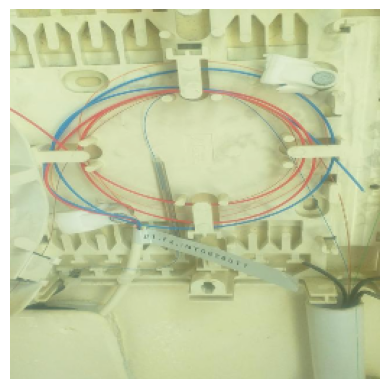

In [22]:
show_image(load_image(image_paths[0], SIZE))

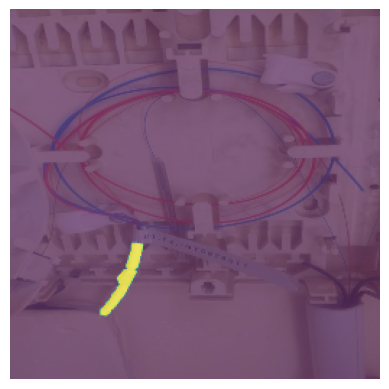

In [23]:
show_mask(load_image(image_paths[0], SIZE), load_image(mask_paths[0], SIZE)[:,:,0], alpha=0.6)

In [24]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

In [25]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }
    
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [28]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(62)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [29]:
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model("base_model\AttentionCustomUNet.h5", custom_objects={
    'EncoderBlock': EncoderBlock,
    'AttentionGate': AttentionGate,
    'DecoderBlock': DecoderBlock
})

In [33]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)

cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("retrainedModel.h5", save_best_only=True),
    ShowProgress()
]

Epoch 1/10
1/1 [==============================] - 1s 1s/step- loss: 0.0305 - accuracy: 0.9931 - IoU: 0.49


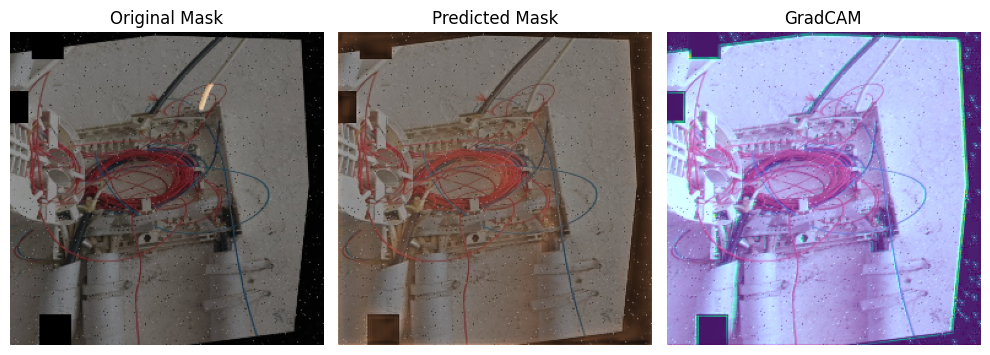

34/34 [==============================] - 313s 9s/step - loss: 0.0305 - accuracy: 0.9931 - IoU: 0.4990 - val_loss: 0.0893 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 2/10
1/1 [==============================] - 0s 338ms/steposs: 0.0263 - accuracy: 0.9929 - IoU: 0.49


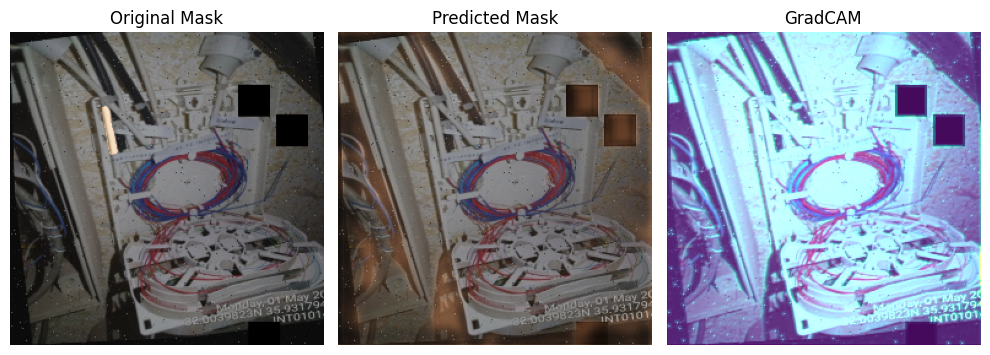

34/34 [==============================] - 347s 10s/step - loss: 0.0263 - accuracy: 0.9929 - IoU: 0.4989 - val_loss: 0.0488 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 3/10
1/1 [==============================] - 0s 227ms/steposs: 0.0233 - accuracy: 0.9935 - IoU: 0.49


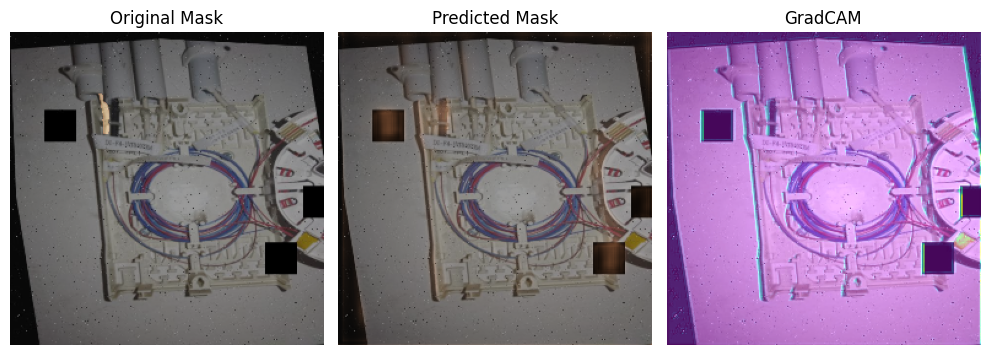

34/34 [==============================] - 290s 8s/step - loss: 0.0233 - accuracy: 0.9935 - IoU: 0.4991 - val_loss: 0.0274 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 4/10
1/1 [==============================] - 0s 359ms/steposs: 0.0251 - accuracy: 0.9930 - IoU: 0.49


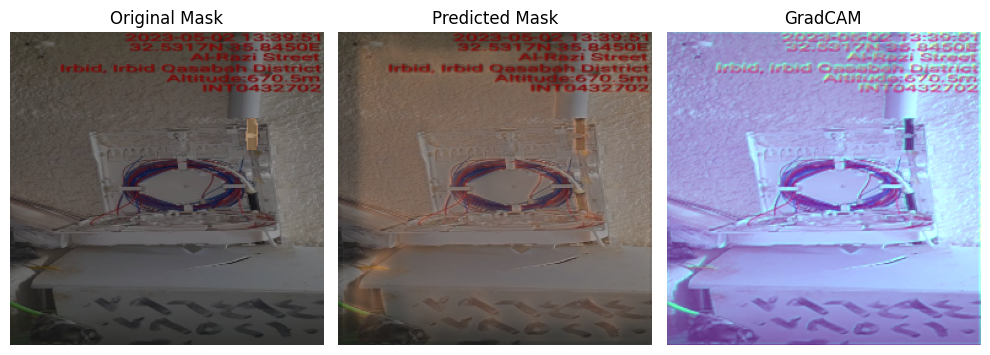

34/34 [==============================] - 317s 9s/step - loss: 0.0251 - accuracy: 0.9930 - IoU: 0.4989 - val_loss: 0.0781 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 5/10
1/1 [==============================] - 0s 233ms/steposs: 0.0241 - accuracy: 0.9932 - IoU: 0.49


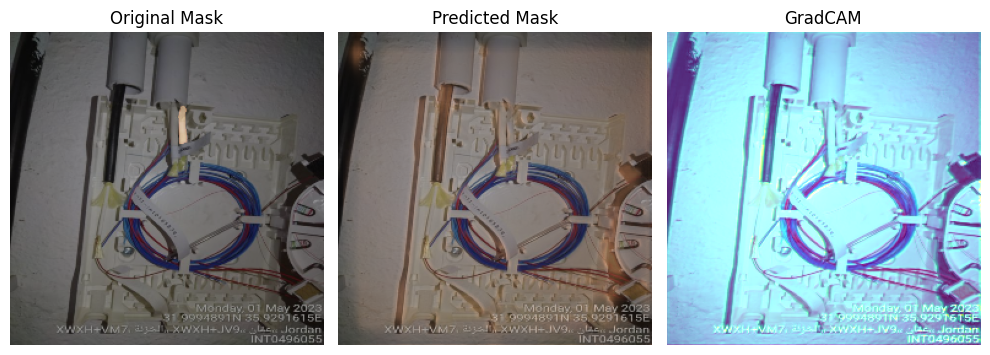

34/34 [==============================] - 271s 8s/step - loss: 0.0241 - accuracy: 0.9932 - IoU: 0.4990 - val_loss: 0.0513 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 6/10
1/1 [==============================] - 0s 239ms/steposs: 0.0236 - accuracy: 0.9932 - IoU: 0.49


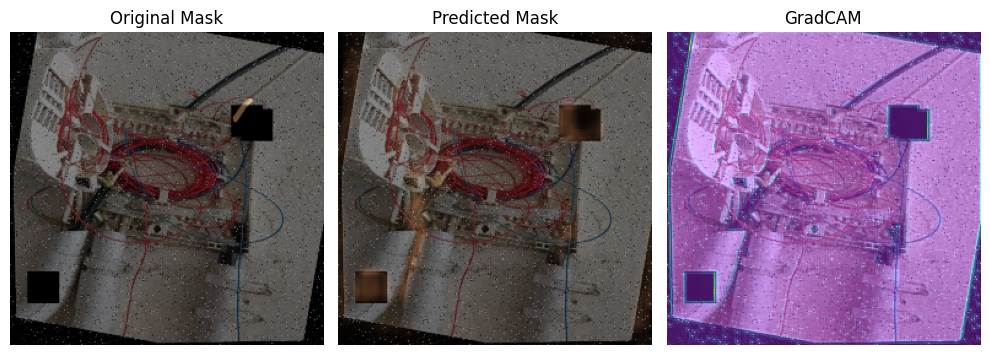

34/34 [==============================] - 283s 8s/step - loss: 0.0236 - accuracy: 0.9932 - IoU: 0.4990 - val_loss: 0.0225 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 7/10
1/1 [==============================] - 0s 218ms/steposs: 0.0217 - accuracy: 0.9932 - IoU: 0.49


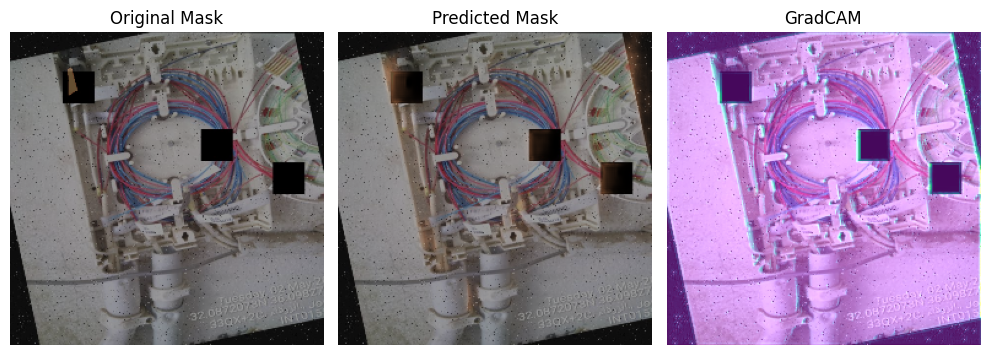

34/34 [==============================] - 274s 8s/step - loss: 0.0217 - accuracy: 0.9932 - IoU: 0.4990 - val_loss: 0.0225 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 8/10
1/1 [==============================] - 0s 312ms/steposs: 0.0225 - accuracy: 0.9931 - IoU: 0.49


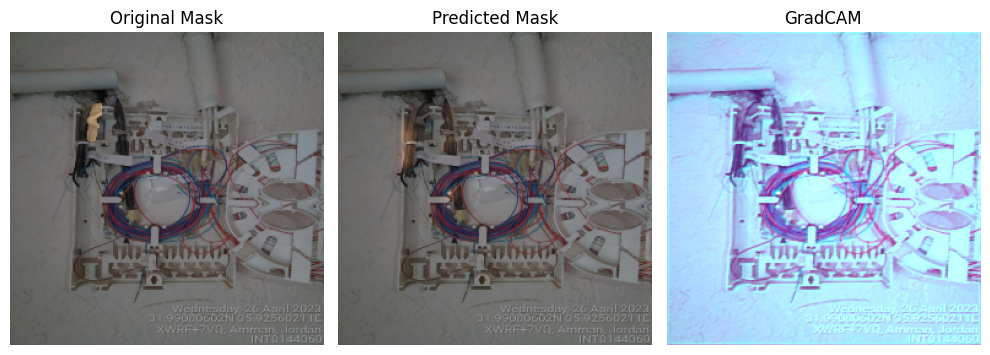

34/34 [==============================] - 278s 8s/step - loss: 0.0225 - accuracy: 0.9931 - IoU: 0.4989 - val_loss: 0.0243 - val_accuracy: 0.9930 - val_IoU: 0.4990
Epoch 9/10
1/1 [==============================] - 0s 350ms/step


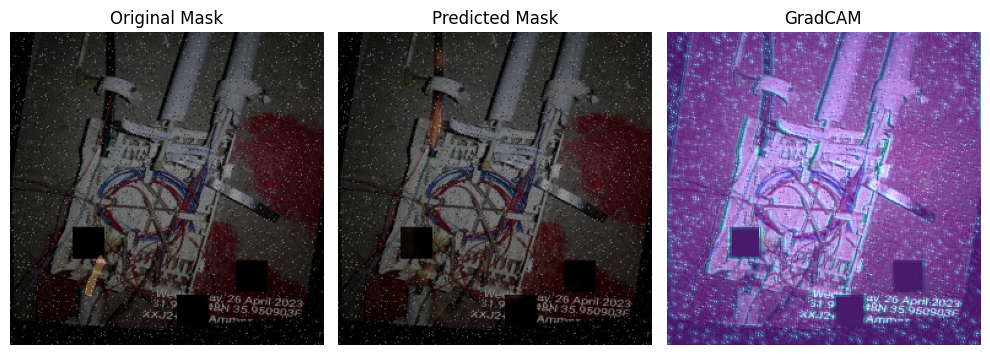

34/34 [==============================] - 97s 3s/step - loss: 0.0207 - accuracy: 0.9935 - IoU: 0.4991 - val_loss: 0.0249 - val_accuracy: 0.9930 - val_IoU: 0.4990


In [34]:
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs=10, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)